In [8]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
import torchvision.models as models
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = models.resnet50(pretrained=True,progress=True)
resnet50.to(device)
softmax = nn.Softmax(dim=1)

In [10]:
img = cv2.imread("merged_image.jpg")
img_size = (256,256)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_trans = transforms.Compose([transforms.ToTensor(),transforms.Resize(img_size),norm])
img = img_trans(img)
img = img.unsqueeze(0)

In [11]:
resnet50.eval()
with torch.no_grad():
    out = softmax(resnet50(img.to(device))).cpu().numpy()[0]

top5 = np.sort(out)[:-6:-1]
top5id = np.argsort(out)[:-6:-1]
SYNSET_FILE = '1000.txt'
synset = open(SYNSET_FILE).read().split('\n')
for i in range(5):
    print("[%d] %.8f %s" % (i+1,top5[i],synset[top5id[i]]))


[1] 0.11682345 n01687978 agama
[2] 0.10299535 n01734418 king snake, kingsnake
[3] 0.09985047 n01677366 common iguana, iguana, Iguana iguana
[4] 0.05582221 n01689811 alligator lizard
[5] 0.05053151 n01693334 green lizard, Lacerta viridis


In [12]:
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
from PIL import Image
import cv2
from functools import partial
import matplotlib.pyplot as plt
import torch.nn as nn

def hook(module, input, output, feature_blob):
    feature_blob.append(output.data.numpy())

def load_image(img):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize
    ])

    image = preprocess(img)
    return Variable(image.unsqueeze(0))

def get_labels():
    SYNSET_FILE = '1000.txt'
    synset = open(SYNSET_FILE).read().split('\n')
    return synset

def compute_cam(activation, softmax_weight, class_ids):
    b, c, h, w = activation.shape
    cams = []
    idx = int(class_ids)
    activation = activation.reshape(c, h * w)
    cam = softmax_weight[idx].dot(activation)
    cam = cam.reshape(h, w)
    cam =  (cam - cam.min()) / (cam.max() - cam.min())
    cam = np.uint8(255 * cam)
    cams.append(cv2.resize(cam, (256, 256)))
    return cams

def make_heatmap(img):
    model = models.resnet50(pretrained = True)
    final_conv_layer = 'layer4'
    model.eval()
    feature_blob = []
    model._modules.get(final_conv_layer).register_forward_hook(partial(hook, feature_blob = feature_blob))
    params = list(model.parameters())
    softmax_weight = np.squeeze(params[-2].data.numpy())
    output = model(Variable(img))  
    labels = get_labels()
    softmax = nn.Softmax(dim=1)
    probs = softmax(output).data.squeeze()
    probs, idx = probs.sort(0, descending = True)
    for i in range(5):
        print(f'{probs[i]:.3f} -> {labels[int(idx[i])]}')
    cams = compute_cam(feature_blob[0], softmax_weight, idx[0])
    img = cv2.imread('merged_image.jpg')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(cams[0], (w, h)), cv2.COLORMAP_RAINBOW)
    return heatmap
    
img = cv2.imread('merged_image.jpg')
img_size = (256,256)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_trans = transforms.Compose([transforms.ToTensor(),transforms.Resize(img_size),norm])
img = img_trans(img)
img = img.unsqueeze(0)
make_heatmap(img)

0.117 -> n01687978 agama
0.103 -> n01734418 king snake, kingsnake
0.100 -> n01677366 common iguana, iguana, Iguana iguana
0.056 -> n01689811 alligator lizard
0.051 -> n01693334 green lizard, Lacerta viridis


array([[[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [  0, 100, 255],
        [  0, 100, 255],
        [  0, 100, 255]],

       [[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [  0, 100, 255],
        [  0, 100, 255],
        [  0, 100, 255]],

       [[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [  0, 100, 255],
        [  0, 100, 255],
        [  0, 100, 255]],

       ...,

       [[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [200,  55,   0],
        [200,  55,   0],
        [200,  55,   0]],

       [[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [200,  55,   0],
        [200,  55,   0],
        [200,  55,   0]],

       [[  0,  85, 255],
        [  0,  85, 255],
        [  0,  85, 255],
        ...,
        [200,  55,   0],
        [200,  55,   0],
        [200,  55,   0]]

0.329 -> n01806143 peacock
0.112 -> n04589890 window screen
0.092 -> n01687978 agama
0.043 -> n02808304 bath towel
0.025 -> n03485794 handkerchief, hankie, hanky, hankey


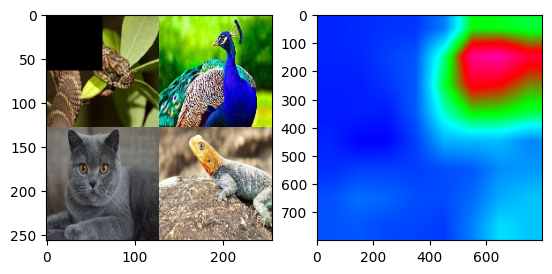

0.272 -> n01806143 peacock
0.133 -> n04589890 window screen
0.106 -> n01687978 agama
0.039 -> n02808304 bath towel
0.028 -> n03485794 handkerchief, hankie, hanky, hankey


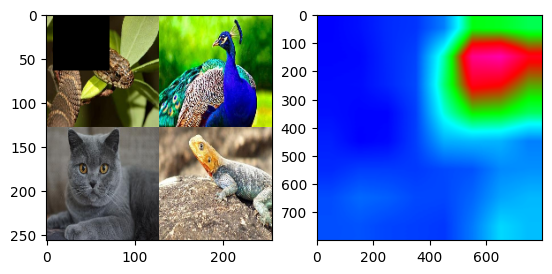

0.155 -> n01687978 agama
0.154 -> n01806143 peacock
0.103 -> n01675722 banded gecko
0.046 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus
0.040 -> n01695060 Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis


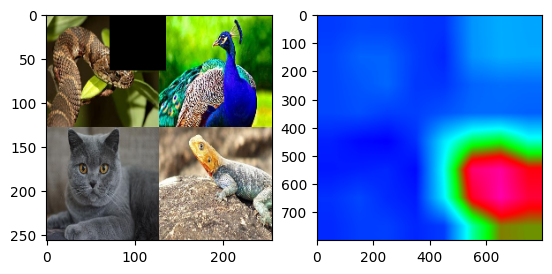

0.199 -> n01675722 banded gecko
0.082 -> n04589890 window screen
0.074 -> n01687978 agama
0.066 -> n01694178 African chameleon, Chamaeleo chamaeleon
0.044 -> n01688243 frilled lizard, Chlamydosaurus kingi


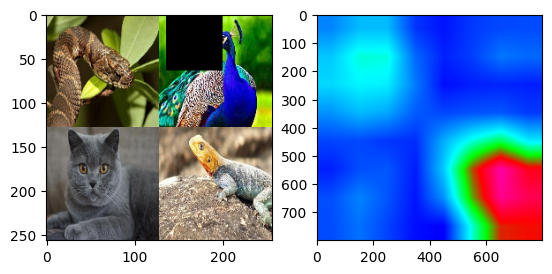

0.114 -> n01675722 banded gecko
0.096 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.089 -> n01687978 agama
0.085 -> n01694178 African chameleon, Chamaeleo chamaeleon
0.054 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


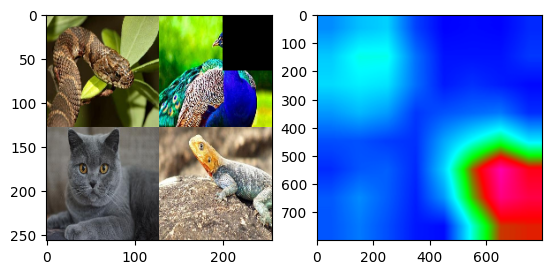

0.338 -> n01806143 peacock
0.151 -> n04589890 window screen
0.083 -> n01687978 agama
0.032 -> n02808304 bath towel
0.022 -> n01675722 banded gecko


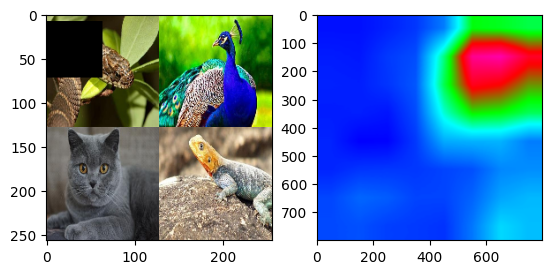

0.344 -> n01806143 peacock
0.101 -> n04589890 window screen
0.098 -> n01687978 agama
0.029 -> n02808304 bath towel
0.027 -> n01675722 banded gecko


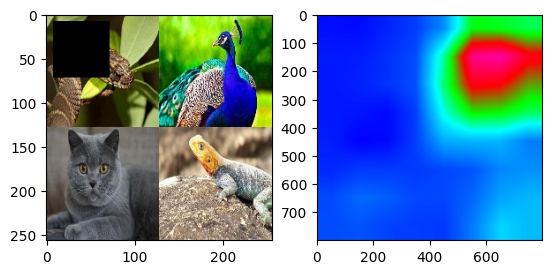

0.169 -> n01687978 agama
0.152 -> n01806143 peacock
0.091 -> n01675722 banded gecko
0.052 -> n01695060 Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
0.031 -> n01688243 frilled lizard, Chlamydosaurus kingi


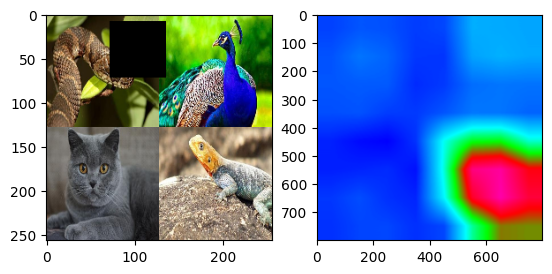

0.222 -> n01675722 banded gecko
0.097 -> n01687978 agama
0.055 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.051 -> n04589890 window screen
0.048 -> n01694178 African chameleon, Chamaeleo chamaeleon


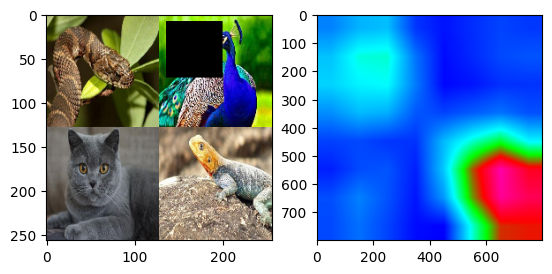

0.123 -> n01675722 banded gecko
0.087 -> n01687978 agama
0.076 -> n01694178 African chameleon, Chamaeleo chamaeleon
0.069 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.062 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


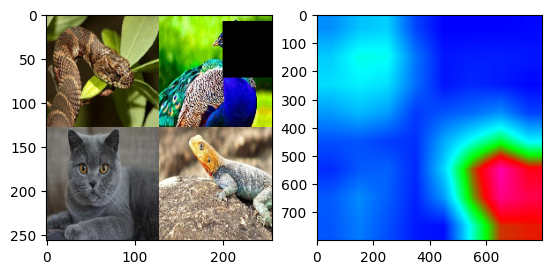

0.446 -> n01806143 peacock
0.077 -> n01687978 agama
0.053 -> n01695060 Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
0.050 -> n01675722 banded gecko
0.050 -> n01692333 Gila monster, Heloderma suspectum


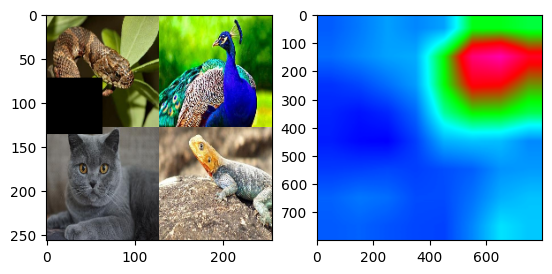

0.415 -> n01806143 peacock
0.092 -> n01687978 agama
0.045 -> n01695060 Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis
0.043 -> n04589890 window screen
0.033 -> n01675722 banded gecko


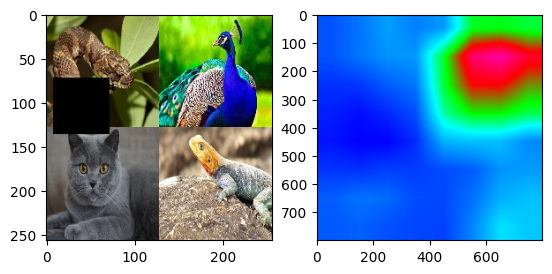

0.175 -> n01806143 peacock
0.098 -> n01687978 agama
0.089 -> n01675722 banded gecko
0.052 -> n04589890 window screen
0.040 -> n01695060 Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis


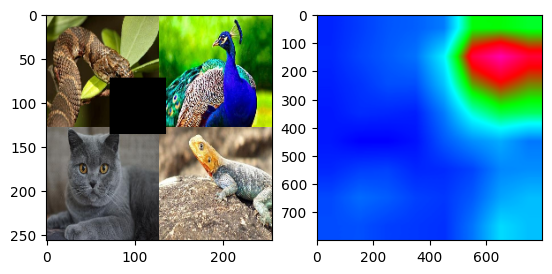

0.173 -> n01675722 banded gecko
0.130 -> n01687978 agama
0.099 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.042 -> n04589890 window screen
0.042 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


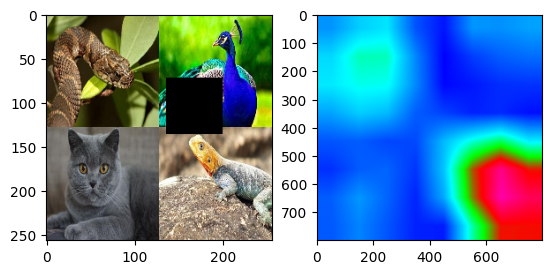

0.185 -> n01675722 banded gecko
0.081 -> n01687978 agama
0.073 -> n04589890 window screen
0.065 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.058 -> n01694178 African chameleon, Chamaeleo chamaeleon


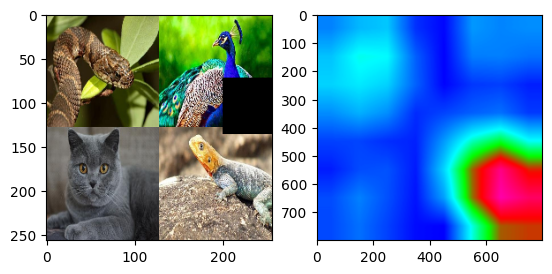

0.205 -> n01687978 agama
0.109 -> n01806143 peacock
0.096 -> n01675722 banded gecko
0.068 -> n01692333 Gila monster, Heloderma suspectum
0.053 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


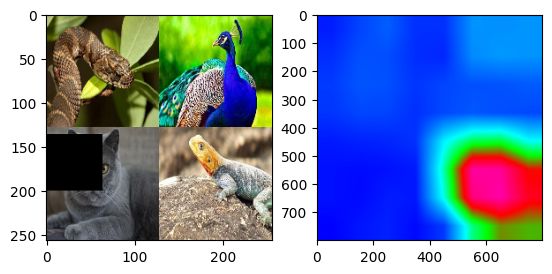

0.201 -> n01687978 agama
0.134 -> n01806143 peacock
0.098 -> n01675722 banded gecko
0.060 -> n01692333 Gila monster, Heloderma suspectum
0.049 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


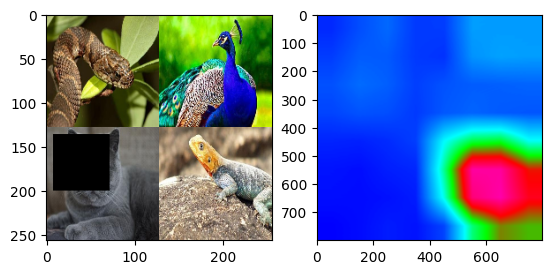

0.192 -> n01806143 peacock
0.106 -> n01687978 agama
0.084 -> n01675722 banded gecko
0.053 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus
0.047 -> n01688243 frilled lizard, Chlamydosaurus kingi


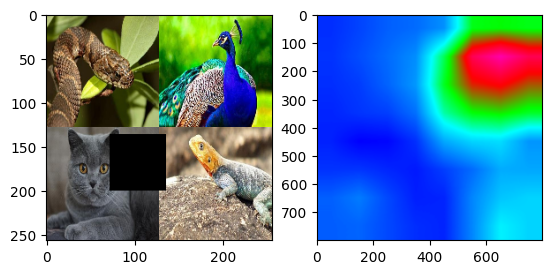

0.381 -> n01806143 peacock
0.177 -> n04589890 window screen
0.073 -> n01797886 ruffed grouse, partridge, Bonasa umbellus
0.049 -> n01806567 quail
0.019 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


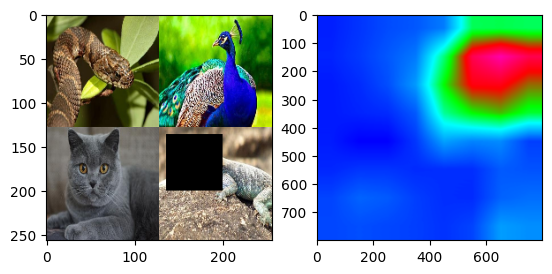

0.241 -> n01806143 peacock
0.102 -> n04589890 window screen
0.091 -> n01806567 quail
0.046 -> n01797886 ruffed grouse, partridge, Bonasa umbellus
0.018 -> n03532672 hook, claw


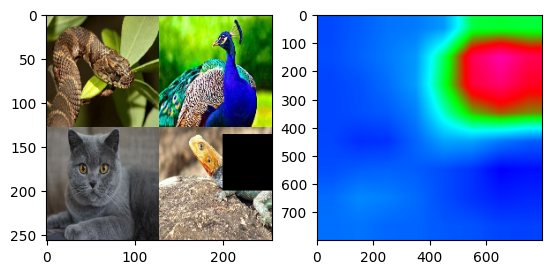

0.188 -> n01806143 peacock
0.135 -> n01687978 agama
0.084 -> n01675722 banded gecko
0.040 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.036 -> n04589890 window screen


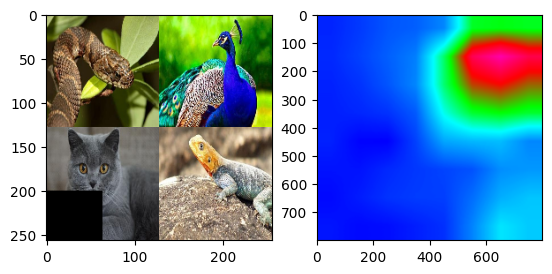

0.204 -> n01806143 peacock
0.133 -> n01687978 agama
0.085 -> n01675722 banded gecko
0.038 -> n04589890 window screen
0.036 -> n01688243 frilled lizard, Chlamydosaurus kingi


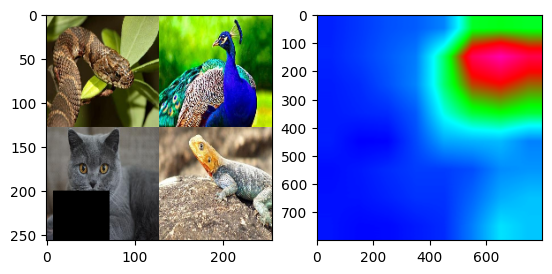

0.231 -> n01806143 peacock
0.122 -> n01687978 agama
0.093 -> n01675722 banded gecko
0.036 -> n01688243 frilled lizard, Chlamydosaurus kingi
0.034 -> n04589890 window screen


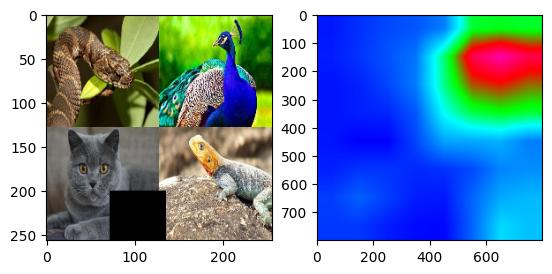

0.186 -> n01806143 peacock
0.143 -> n04589890 window screen
0.047 -> n01806567 quail
0.038 -> n01797886 ruffed grouse, partridge, Bonasa umbellus
0.036 -> n02808304 bath towel


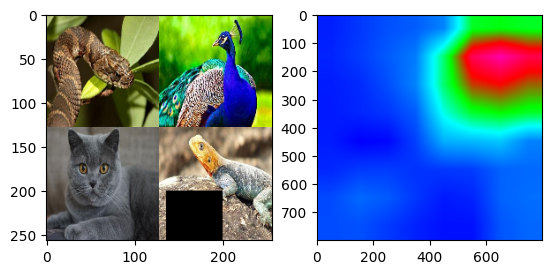

0.207 -> n04589890 window screen
0.157 -> n01806143 peacock
0.064 -> n01797886 ruffed grouse, partridge, Bonasa umbellus
0.030 -> n01806567 quail
0.026 -> n01755581 diamondback, diamondback rattlesnake, Crotalus adamanteus


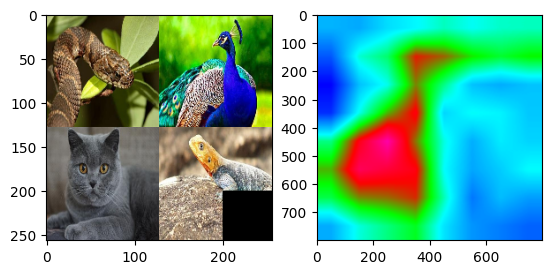

In [13]:
img = cv2.imread('merged_image.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_size = (256,256)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_trans = transforms.Compose([transforms.ToTensor(),transforms.Resize(img_size)])
img = img_trans(img)
img = img.unsqueeze(0)

for x in range(-56,247,64):
    for y in range(-56,247,64):
        mask = torch.zeros_like(img,dtype=torch.bool)
        if x<0:
            x = 0
        if y<0:
            y = 0
        if x+64>256:
            max_x = 256
        else: max_x = x+64
        if y+64>256:
            max_y = 256
        else: max_y = y+64
        mask[:,:,x:max_x,y:max_y] = 1
        img_mask = img.clone()
        img_mask[mask] = 0
        plt.subplot(121)
        plt.imshow(np.transpose(img_mask.numpy(),(0,2,3,1))[0])
        save_img = make_heatmap(img_mask)
        plt.subplot(122)
        plt.imshow(save_img)
        plt.show()
